In [1]:
!cp drive/MyDrive/Colab\ Notebooks/train.zip .

In [2]:
!unzip -qq train.zip -d dogs-vs-cats

In [3]:
!ls -l dogs-vs-cats/

total 768
drwxr-xr-x 2 root root 782336 Sep 20  2013 train


In [4]:
import numpy as np
from glob import glob
import cv2, os, random
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [7]:
path='dogs-vs-cats/train'

In [8]:
ROW, COL = 96, 96

dogs, cats = [], []
y_dogs, y_cats = [], []

In [9]:
def load_dogs():
    print('Loading all dog images\n')
    dog_path = os.path.join(path, 'dog*')
    for dog_img in glob(dog_path):
        dog = cv2.imread(dog_img)
        dog = cv2.cvtColor(dog, cv2.COLOR_BGR2GRAY)
        dog = cv2.resize(dog, (ROW, COL))
        dog = image.img_to_array(dog)
        dogs.append(dog)
    print('All dog images loaded')

In [10]:
def load_cats():
    print('Loading all cat images\n')
    cat_path = os.path.join(path, 'cat*')
    for cat_img in glob(cat_path):
        cat = cv2.imread(cat_img)
        cat = cv2.cvtColor(cat, cv2.COLOR_BGR2GRAY)
        cat = cv2.resize(cat, (ROW, COL))
        cat = image.img_to_array(cat)
        cats.append(cat)
    print('All cat images loaded')

In [11]:
def show_dogs():
    plt.figure(figsize=(12,4))    
    for i in range(5):
        plt.subplot(1, 5, i+1)
        img = image.array_to_img(random.choice(dogs))
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        
        plt.axis('off')
        plt.title(f'Supposed to be a {classes[0]}')        
    plt.show()

In [12]:
def show_cats():
    plt.figure(figsize=(12,4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        img = image.array_to_img(random.choice(cats))
        plt.imshow(img, cmap=plt.get_cmap('gray'))

        plt.axis('off')
        plt.title(f'Supposed to be a {classes[1]}')
    plt.show()

In [13]:
load_dogs()

Loading all dog images

All dog images loaded


In [14]:
load_cats()

Loading all cat images

All cat images loaded


In [15]:
classes = ['dog', 'cat']

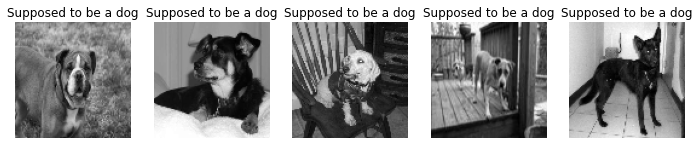

In [16]:
show_dogs()

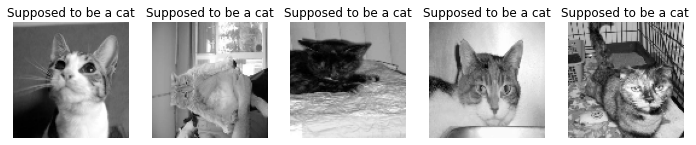

In [17]:
show_cats()

In [18]:
y_dogs = [1 for item in enumerate(dogs)]
y_cats = [0 for item in enumerate(cats)]

In [19]:
dogs = np.asarray(dogs).astype('float32') / 255
cats = np.asarray(cats).astype('float32') / 255
y_dogs = np.asarray(y_dogs).astype('int32')
y_cats = np.asarray(y_cats).astype('int32')

In [20]:
X = np.concatenate((dogs, cats), axis=0)
y = np.concatenate((y_dogs, y_cats), axis=0)

In [21]:
X.shape, y.shape

((25000, 96, 96, 1), (25000,))

In [22]:
IMG_CHANNEL = 1
BATCH_SIZE = 128
N_EPOCH = 30
VERBOSE = 2
VALIDAION_SPLIT = 0.2
OPTIM = Adam()
N_CLASSES = len(classes)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=seed
)

In [24]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, N_CLASSES)
y_test = to_categorical(y_test, N_CLASSES)

In [25]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(ROW, COL, IMG_CHANNEL), activation='relu'),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(.25),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(.5),
    Dense(N_CLASSES, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0

In [26]:
model.compile(loss='categorical_crossentropy', 
              optimizer=OPTIM, metrics=['accuracy'])

In [27]:
modelpath = 'model/dogs_vs_cats_redux_checkpoint.h5'
checkpoint = ModelCheckpoint(filepath=modelpath, save_best_only=True, verbose=1)

In [28]:
history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, epochs=N_EPOCH, 
                    validation_split=VALIDAION_SPLIT,
                    verbose=VERBOSE, callbacks=[checkpoint])

Epoch 1/30
125/125 - 17s - loss: 0.7018 - accuracy: 0.5387 - val_loss: 0.6660 - val_accuracy: 0.5763

Epoch 00001: val_loss improved from inf to 0.66603, saving model to model/dogs_vs_cats_redux_checkpoint.h5
Epoch 2/30
125/125 - 9s - loss: 0.6074 - accuracy: 0.6658 - val_loss: 0.5544 - val_accuracy: 0.7100

Epoch 00002: val_loss improved from 0.66603 to 0.55442, saving model to model/dogs_vs_cats_redux_checkpoint.h5
Epoch 3/30
125/125 - 9s - loss: 0.5338 - accuracy: 0.7271 - val_loss: 0.5089 - val_accuracy: 0.7487

Epoch 00003: val_loss improved from 0.55442 to 0.50891, saving model to model/dogs_vs_cats_redux_checkpoint.h5
Epoch 4/30
125/125 - 9s - loss: 0.4797 - accuracy: 0.7697 - val_loss: 0.4626 - val_accuracy: 0.7840

Epoch 00004: val_loss improved from 0.50891 to 0.46262, saving model to model/dogs_vs_cats_redux_checkpoint.h5
Epoch 5/30
125/125 - 9s - loss: 0.4306 - accuracy: 0.8002 - val_loss: 0.4242 - val_accuracy: 0.8020

Epoch 00005: val_loss improved from 0.46262 to 0.42422

In [29]:
acc = model.evaluate(X_test, y_test, verbose=2)[1]
print('MODEL ACCURACY: %.5f' % acc)

157/157 - 1s - loss: 0.8080 - accuracy: 0.8320
MODEL ACCURACY: 0.83200


In [30]:
from tensorflow.keras.models import load_model
best_model = load_model(modelpath)
acc = best_model.evaluate(X_test, y_test, verbose=2)[1]
print('Best model accuracy: %.5f' % acc)

157/157 - 1s - loss: 0.3966 - accuracy: 0.8336
Best model accuracy: 0.83360


In [31]:
# 검증셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']

# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

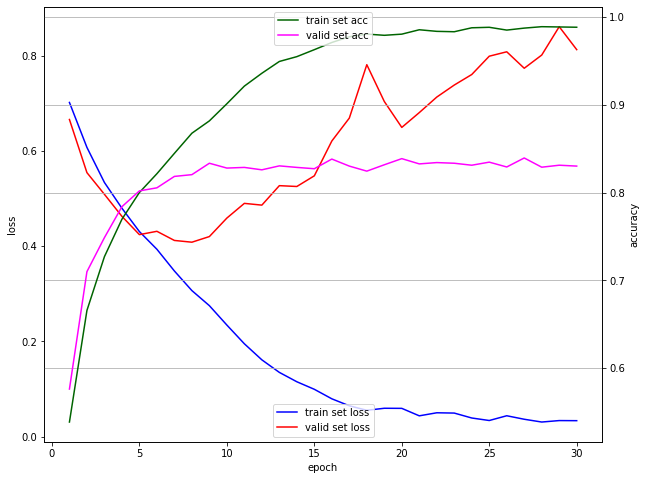

In [32]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='train set loss')
ax0.plot(x_len, y_vloss, c="red", label='valid set loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='train set acc')
ax1.plot(x_len, y_vacc, c="magenta", label='valid set acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()